Class for NAND-CIRC programming language

In [26]:
from math import log, floor

In [27]:
def int2bin(n, num_bits = None, least_sig_first = True):
        if num_bits == None:
            if n == 0:
                return '0'
            else:
                num_bits = floor(log(n, 2) + 1)
        s = bin(n)[2:]
        len_s = len(s)
        if len_s > num_bits:
            raise Exception('Decimal {} cannot be represented with {} bits'.format(n, num_bits))
        elif len_s < num_bits:
            s = '0'*(num_bits - len_s) + s
        if least_sig_first:
            return ''.join(reversed(s))
        else:
            return s
def bin2int(s, least_sig_first = True):
    if s == '':
        return 0
    if not least_sig_first:
        s = ''.join(reversed(s))
    return int(s[0]) + 2 * bin2int(s[1:])
def NAND(a, b):
    if a != 0 and a != 1:
        raise Exception('NAND input {}, expecting 0 or 1'.format(a))
    if b != 0 and b!= 1:
        raise Exception('NAND input {}, expecting 0 or 1'.format(b))
    return 1 - a * b

In [28]:
class NAND_CIRC:
    def __init__(self, num_inputs, num_outputs):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_working = 0
        self.valued_vars = []
        for i in range(num_inputs):
            self.valued_vars.append('X[{}]'.format(i))
        self.program = []
        
    def allocate(self):
        w = 'W[{}]'.format(self.num_working)
        self.num_working += 1
        return w
    
    def input_var(self, i):
        n = self.num_inputs
        if i >= n:
            raise Exception('This program only has {} input variables'.format(n))
        return 'X[{}]'.format(i)
    
    def output_var(self, i):
        m = self.num_outputs
        if i >= m:
            raise Exception('This program only has {} output variables'.format(m))
        return 'Y[{}]'.format(i)
            
    def is_w(var):
        return var[0] == 'W'
    
    def is_x(var):
        return var[0] == 'X'
    
    def is_y(var):
        return var[0] == 'Y'
        
    def index(var):
        return int(var[2:-1])
    
    def check_format(var):
        if len(var) < 4:
            formatted = False
        else:
            formatted = (var[1] == '[' and var[-1] == ']') and (NAND_CIRC.is_w(var) or NAND_CIRC.is_x(var) or NAND_CIRC.is_y(var))
            try:
                NAND_CIRC.index(var)
            except:
                formatted = False
        if not formatted:
            raise Exception('NAND variable {} is improperly formatted'.format(var))
        
    def check_index(self, var):
        i = NAND_CIRC.index(var)
        if NAND_CIRC.is_w(var) and i >= self.num_working:
            raise Exception('Program has {} working variables: NAND variable {} is out of range'.format(self.num_working, var))
        if NAND_CIRC.is_x(var) and i >= self.num_inputs:
            raise Exception('Program has {} input variables: NAND variable {} is out of range'.format(self.num_inputs, var))
        if NAND_CIRC.is_y(var) and i >= self.num_outputs:
            raise Exception('Program has {} output variables: NAND variable {} is out of range'.format(self.num_outputs, var))
        
    def check_input(self, inz):
        if NAND_CIRC.is_y(inz):
            raise Exception('NAND input variable {} cannot be one of the program\'s output variables'.format(inz))
        if inz not in self.valued_vars:
            raise Exception('NAND input variable {} is not a function of the program\'s input variables'.format(inz))
    
    def check_output(self, out):
        if NAND_CIRC.is_x(out):
            raise Exception('NAND output variable {} cannot be one of the program\'s input variables'.format(out))
        if out in self.valued_vars:
            raise Exception('NAND output variable {} is already the output of another NAND gate'.format(out))
        
    def NAND(self, out, in0, in1):
        triple = (out, in0, in1)
        [NAND_CIRC.check_format(z) for z in triple]
        [self.check_index(z) for z in triple]
        self.check_input(in0)
        self.check_input(in1)
        self.check_output(out)
        self.valued_vars.append(out)
        self.program.append(triple)
    
    def NOT(self, out, in0):
        self.NAND(out, in0, in0)
    
    def AND(self, out, in0, in1):
        temp = self.allocate()
        self.NAND(temp, in0, in1)
        self.NOT(out, temp)
    
    def OR(self, out, in0, in1):
        not_0 = self.allocate()
        self.NOT(not_0, in0)
        not_1 = self.allocate()
        self.NOT(not_1, in1)
        self.NAND(out, not_0, not_1)
    
    def IF(self, out, cond, in0, in1):
        notcond = self.allocate()
        self.NOT(notcond, cond)
        temp_0 = self.allocate()
        self.NAND(temp_0, in0, cond)
        temp_1 = self.allocate()
        self.NAND(temp_1, in1, notcond)
        self.NAND(out, temp_0, temp_1)
    
    def num_vars(self):
        counter = self.num_inputs + self.num_outputs
        for triple in self.program:
            out, _, _ = triple
            if NAND_CIRC.is_w(out):
                counter += 1
        return counter
    
    def var_length(self):
        return len(int2bin(self.num_vars() - 1))
    
    def index_program(self):
        n = self.num_vars()
        w_seen = {}
        w_counter = [self.num_inputs]
        def f(var):
            if NAND_CIRC.is_w(var):
                if var not in w_seen:
                    w_seen[var] = w_counter[0]
                    w_counter[0] += 1
                return w_seen[var]
            elif NAND_CIRC.is_x(var):
                return NAND_CIRC.index(var)
            else:
                return n - self.num_outputs + NAND_CIRC.index(var)
        p = []
        for triple in self.program:
            p.append(tuple([f(var) for var in triple]))
        return p
    
    def circ2str(self):
        var_len = self.var_length()
        b = lambda x : int2bin(x, var_len)
        prefix = ''
        for char in int2bin(var_len):
            prefix += 2*char
        s = prefix + '01'
        s += b(self.num_inputs)
        s += b(self.num_outputs)
        for triple in self.index_program():
            out, in0, in1 = triple
            s += b(out)
            s += b(in0)
            s += b(in1)
        return s

In [29]:
def split(s, i):
    return s[0:i], s[i:]

def check_str(s):
    t = type(s)
    if t != str:
        raise Exception('Invalid string: {} is of type {}, expecting type str'.format(s, t))
    for b in s:
        if b != '0' and b != '1':
            raise Exception('Invalid string: {} contains the character {}, expecting 0 or 1'.format(s, b))

In [30]:
def EVAL(p, x):
    full_p = p
    check_str(p), check_str(x)
    invalid_encoding = 'Invalid NAND-CIRC encoding: {}'.format(full_p)
    if p[0] != p[1]:
        raise Exception(invalid_encoding)
    i = 0
    var_len = 0
    while True:
        if p[2 * i] == p[2 * i + 1]:
            var_len += int(p[2 * i]) * 2 ** i
            i += 1
        else:
            i += 1
            break
    p = p[2 * i:]
    if len(p) < var_len * 2:
        raise Exception(invalid_encoding)
    num_inputs, p = split(p, var_len)
    num_outputs, p = split(p, var_len)
    num_inputs, num_outputs = bin2int(num_inputs), bin2int(num_outputs)
    if len(p) % (var_len * 3) != 0:
        raise Exception(invalid_encoding)
    if len(x) != num_inputs:
        raise Exception('Program {} takes inputs of length {}, input {} is of length {}'.format(full_p, num_inputs, x, len(x)))
    vars = {}
    b = lambda i : int2bin(i, var_len)
    for i in range(num_inputs):
        vars[b(i)] = int(x[i])
    while p != '':
        out, p = split(p, var_len)
        in0, p = split(p, var_len)
        in1, p = split(p, var_len)
        vars[out] = NAND(vars[in0], vars[in1])
    output = ''
    num_vars = len(vars)
    for i in range(num_vars - num_outputs, num_vars):
        output += str(vars[b(i)])
    return output

In [31]:
def LOOKUP(k):
    num_inputs = 2 ** k + k
    p = NAND_CIRC(num_inputs, 1)
    if k <= 0:
        raise Exception('Input {} must be at least 1 to create non-trivial NAND-CIRC program'.format(k))
    IF_inputs = [p.input_var(i) for i in range(2 ** k)]
    for i in range(k - 1):
        cond = p.input_var(num_inputs - i - 1)
        next_IF_inputs = []
        for j in range(int(len(IF_inputs) / 2)):
            out = p.allocate()
            p.IF(out, cond, IF_inputs[2 * j + 1], IF_inputs[2 * j])
            next_IF_inputs.append(out)
        IF_inputs = next_IF_inputs
    out = p.output_var(0)
    cond = p.input_var(num_inputs - k)
    p.IF(out, cond, IF_inputs[1], IF_inputs[0])
    return p.circ2str()

In [32]:
p = NAND_CIRC(2,1)
print(p.program)

[]


In [33]:
a = p.allocate()
b = p.allocate()
b = p.allocate()
print(a)

W[0]


In [34]:
p.NAND(a, p.input_var(0), p.input_var(1))
p.NAND(b, a, p.input_var(0))
p.NAND(p.output_var(0), a, b)
print(p.program)


[('W[0]', 'X[0]', 'X[1]'), ('W[2]', 'W[0]', 'X[0]'), ('Y[0]', 'W[0]', 'W[2]')]


In [35]:
p.index_program()

[(2, 0, 1), (3, 2, 0), (4, 2, 3)]

In [36]:
s = p.circ2str()

In [37]:
x = '10'
EVAL(s, x)

'1'

In [38]:
p = NAND_CIRC(3, 1)
p.IF(p.output_var(0), p.input_var(0), p.input_var(1), p.input_var(2))
s = p.circ2str()
x = '110'
EVAL(s, x)

'1'

In [39]:
LOOKUP(2)

'110011010110010000011001010010100111001000010100000100000001100100101110000010010101010010100110101100010100001100100001010101101101000110011100010000100111101011000100000011001001110100011111000001'

In [40]:
EVAL(s, '001')

'1'

In [41]:
[1].copy()

[1]

In [43]:
k = 3
p = LOOKUP(k)
count = 0
for i in range(2 ** (2 ** k)):
    s = int2bin(i, 2 ** k)
    for j in range(2 ** k):
        actual = s[j]
        lookup = EVAL(p, s + int2bin(j, k, least_sig_first = False))
        if actual == lookup:
            count += 1
trials = 2 ** (2 ** k) * 2 ** k
accuracy = count / trials
print(accuracy)

1.0


In [44]:
a = [0]
a.insert(0, 2)
print(a)

[2, 0]


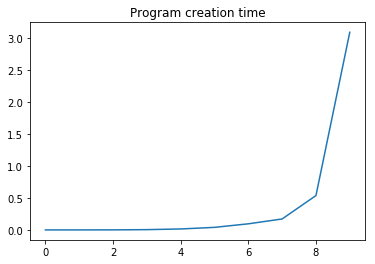

In [76]:
from time import time
import matplotlib.pyplot as plt
times = []

for x in range(2,12):
    start = time()
    LOOKUP(x)
    end = time()
    times.append(end - start)
plt.plot(times)
plt.title('Program creation time')
plt.show()